# Modeling univariate asset return distributions

The last chapter highlights some interesting empirical facts about asset returns. This chapter aims to demonstrate how to develop reasonable stochastic models for asset returns. What is meant by this is a probabilistic model which allows us to quantify the probabilities for certain events of the asset return and gives us the chance to simulate realistic data for asset returns. Nowadays, many machine learning models have an emphasis on prediction, e.g., can we predict tomorrow's asset return, given some information today. This usually gives us the conditional expected value of a random variable. However, if we are interested in more than just that, we may favor the use of a model which fully describes the distribution. For instance, if you want to to assess the probability for a loss exceeding a certain level, you need the full distributional model, or, if you want to simulate data in order to determine the variability of investment strategies you can use the advantages of distributional models.  

In the first part of this chapter, we are going to focus on *unconditional* models for asset returns. This term describes the fact that we derive a model which is capturing what is happening over time, so during good and bad economic conditions. You may picture the outcome of such a model as a way to determine what is happing on average during these times. To do so, we learn about parametric distributions, how to estimate them by maximum likelihood estimation and how to compare different parametric models.

In the second part of this chapter, we are going to focus on the *conditional* perspective of asset return modeling. If you follow price developments on financial markets, you observe different characteristics which depend on the market phase. For instance, starting from the last quarter in 2007 until the beginning of 2009, financial markets experienced financial turmoil and below average performance for the majority of investments which has been triggered by the great financial crisis. This period is followed by a long time of increasing asset prices (at least on stock and some other markets) which has only been stopped by the Covid period that mostly caused price deteriorations in the first half of 2020. The point is, depending on the current state of the market, our expectation regarding the next asset return, its deviation from the mean or its probability for exceeding certain loss levels, may differ. You already observed the phenomena of volatility clustering in the past chapter. So given we observe large deviations from the expected value recently, would you predict rather large deviations in the near future as well? The answer is yes, because this is how asset returns usually behave. 

Finally, we should note that both perspectives, *unconditional* and *conditional* are valid and needed. The unconditional perspective is in line with a long term investment point of view. If you assume you hold an asset for a long time, you are more interested in the characteristics what is happening over time. However, to better understand what can happen with your investment in time, you need the conditional perspective, e.g., if a financial crisis occurs, which loss levels are common and how long do we need to wait until the market recovers. 

## Parametric models 

A parametric model is a model which is fully specified by a finite number of parameters. For instance, assuming asset returns are normally distributed, the model is fully specified by the two parameters of the normal distribution - $\mu, \sigma$. Usually, models which use a higher number of parameters are more flexible in terms of how easy the model can be adjusted to data. At the same time, parameters must be estimated by empirical data. The estimation process is prone to statistical uncertainty which is higher for models with a higher number of parameters, increasing the variance of estimation. At the same time, models with less parameters and lower flexibility are more exposed to bias. 

```{note}
More precise definitions of bias and variance in estimation follow later. 
```

A term which is often used to describe the goal of parametric models is *parsimony*. This refers to desire that a model should use little parameters if possible, however, it should be able to capture characteristics of empirical data. 

Based on certain empirical characteristics which we observed in the past chapter, a broader list of parametric distribution can be taken into account for financial data, i.e., asset returns. Two popular choices are the normal and the (Student) t distribution. Both are symmetric, while the t distribution has heavy tails and, thus, is usually better for capturing occurrences of extreme values for asset returns. Below, we take a look at an example of the empirical distribution of Apple returns which is contrasted with a normal and a t distribution. Visually, we already see the better fit of the t distribution. Note that both distributions are symmetric which may be a problem if the asset return distribution is highly skewed in reality. Python's scipy package comes along with a large number of continuous distributions and even more distributions (especially skewed ones) are available in packages from other statistical languages such as R (especially the fGarch or rugarch package, if you are interested). Let us exemplarily take a look at these two distributions.

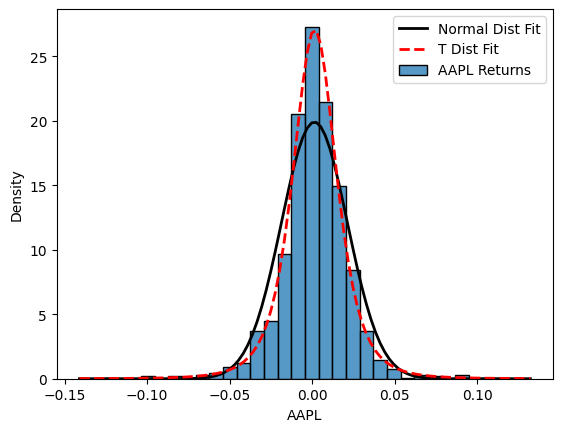

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, norm

df_returns = pd.read_csv("../data/dow_returns.csv")
df_returns.Date = pd.to_datetime(df_returns.Date)
df_returns.set_index("Date", inplace = True)

aapl_returns = df_returns['AAPL']
sns.histplot(aapl_returns, kde=False, bins=30, stat='density', label='AAPL Returns')
mean, std = norm.fit(aapl_returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Dist Fit')
df, loc, scale = t.fit(aapl_returns)
p_t = t.pdf(x, df, loc, scale)
plt.plot(x, p_t, 'r--', linewidth=2, label='T Dist Fit')
plt.legend()
plt.show()

### Normal distribution

The normal distribution is specified by two parameters $\mu, \sigma^2$. The probability density function for a normal distribution is given by:

$$
f(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

For the normal distribution, $\mu$ is equal to the expected value and $\sigma^2$ is equal to the variance of the random variable.

### Student t distribution

The standardized form of the t distribution is specified by the degrees of freedom parameter $\nu$ and the probability density function is defined by:

$$
f(x | \nu) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu\pi}\Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}
$$

Here, $\Gamma$ is the gamma function. While the t distribution is defined for values $\nu > 0$, the variance of a t distributed variable is only finite if $\nu > 2$. The variance is equal to $\frac{\nu}{\nu - 2}$ and the mean is equal to zero. To provide more flexibility regarding the mean and variance of the distribution its values can be transformed by a location and scale parameter. This is how, the t distribution is implemented in the scipy package. One important characteristic of the t distribution are its heavy tails. We spare the technical illustration of heavy tailed distributions here, however, heavy tailed distributions are leptocurtic and have more probabilty mass in the tails of the distribution. This means, more extreme events tend to occur more often in comparison to what we would expect of, e.g., a normal distributed variable. 

### Flexibility of distributional families

Given a density $f(x)$ of a random variable $x$, the distribution can become more flexible in terms of location, scale and skewness. Let us take a look at this by assuming a random variable $x$ which has an expected value $\mu_x$ and variance $\sigma_x^2$. If we add a constant value $l$ to it a new variable can be defined by: $y = x + l$, this variable has an expected value of $\mu_y = \mu_x + l$ and a variance equal to $\sigma_y^2 = \sigma_y^2$. If we further rescale the variable by:

$$
y = l + s \cdot x
$$

its variance is $\sigma_y^2 = s^2 \sigma_y^2$. This means, by location shifting and scaling the mean and variance of every random variable can be adjusted. For instance, for the t distribution, this gives us a more flexible distribution with three parameters, i.e., location, scale and degrees of freedom $\boldsymbol{\theta} = \lbrace l, s, \nu \rbrace$

```{note} Technical background
In general, every density function must fulfill the following conditions:

* $f(x) > 0$ $\forall x \in \mathbb{R}$
* $\int_{-\infty}^{\infty} f(x) dx = 1$

if $x$ has density $f(x)$, then $y = l + s \cdot x$ has density $f \left( \frac{x - l}{s} \right) \frac{1}{s}$
```

In analogous ways skewed distributions can be created out of symmetric ones. This requires the use of another parameter. The figure below demonstrates how location, scale, kurtosis and shape impact the density of the distribution of a continuous random variable.

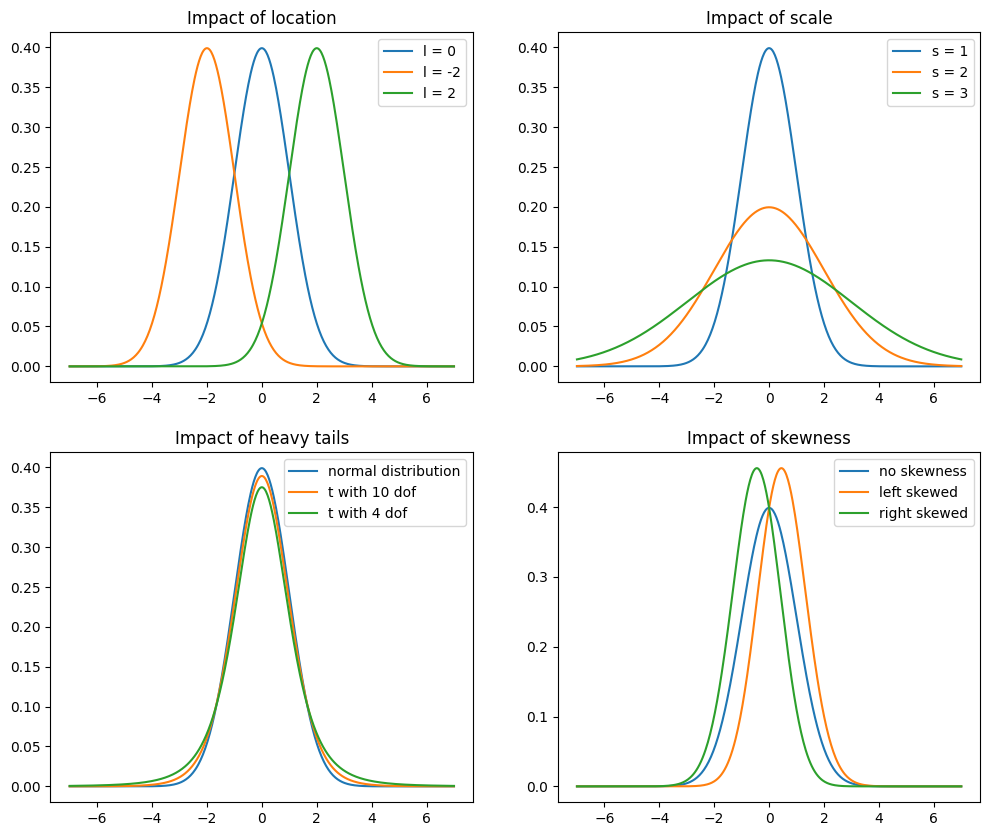

In [2]:
from scipy.stats import norm, t, skewnorm
import matplotlib.pylab as plt

x =  np.linspace(-7, 7, 500)

fig, axs = plt.subplots(2, 2, figsize = (12, 10))
axs[0, 0].plot(x, norm.pdf(x, loc = 0, scale = 1), label = "l = 0")
axs[0, 0].plot(x, norm.pdf(x, loc = -2, scale = 1), label = "l = -2")
axs[0, 0].plot(x, norm.pdf(x, loc = 2, scale = 1), label = "l = 2")
axs[0, 0].set_title("Impact of location")
axs[0, 0].legend()

axs[0, 1].plot(x, norm.pdf(x, loc = 0, scale = 1), label = "s = 1")
axs[0, 1].plot(x, norm.pdf(x, loc = 0, scale = 2), label = "s = 2")
axs[0, 1].plot(x, norm.pdf(x, loc = 0, scale = 3), label = "s = 3")
axs[0, 1].set_title("Impact of scale")
axs[0, 1].legend()

axs[1, 0].plot(x, norm.pdf(x, loc = 0, scale = 1), label = "normal distribution")
axs[1, 0].plot(x, t.pdf(x, df = 10, loc = 0, scale = 1), label = "t with 10 dof")
axs[1, 0].plot(x, t.pdf(x, df = 4, loc = 0, scale = 1), label = "t with 4 dof")
axs[1, 0].set_title("Impact of heavy tails")
axs[1, 0].legend()

axs[1, 1].plot(x, norm.pdf(x, 0, 1), label = "no skewness")
axs[1, 1].plot(x, skewnorm.pdf(x, 0.75, 0, 1), label = "left skewed")
axs[1, 1].plot(x, skewnorm.pdf(x, -0.75, 0, 1), label = "right skewed")
axs[1, 1].set_title("Impact of skewness")
axs[1, 1].legend()
plt.show()

Assuming, we decide which distribution we want to use for modeling an asset return distribution, the important question is how can we select reasonable values for its parameters which finally specify the asset return model. Usually, the parameters are calibrated using data samples from the past. The estimation can be done in different ways, but one popular choice is maximum likelihood estimation which we now discuss. 

## Maximum likelihood estimation

Given a sequence of data $\lbrace x_1, ..., x_T \rbrace $, we may assume that each observation is independent from its previous ones and is identical for every observation $x_t$. Let $f$ be the density function of the distribution, e.g., the normal distribution, and $\boldsymbol{\theta}$ the vector of all parameters for this distribution, e.g., $\begin{pmatrix} \mu & \sigma \end{pmatrix}^{'}$. Given the assumption of independence, the so called likelihood of the data can be determined by the product of the density function value of each observation:

$$
L(\boldsymbol{\theta}) = \prod_{t = 1}^{T} f(x_t | \boldsymbol{\theta})
$$

It is important to understand that the values for $x_t$ are fixed observed values from an empirical sample and the value for $L$ can only be adjusted by choosing different values for the distribution's parameters. The goal of maximum likelihood estimation is to find parameters which result in the highest possible value for $L$. Accordingly, we find ourselves in an optimization problem. As optimization is often done by determining the derivatives of the objective function, the function from above is transformed by the natural log to maximum log-likelihood optimization:

$$
\log\left( L(\boldsymbol{\theta}) \right) = \sum_{i = 1}^{T} \log \left(f(y_t | \boldsymbol{\theta})\right)
$$

This is a technical trick which simplifies the calculation of derivatives and as the log-transformation is strictly monotone, the parameters which maximize $\log\left( L(\boldsymbol{\theta}) \right)$ are the same as the ones which maximize $L(\boldsymbol{\theta})$

The parameter estimator is:

$$
\boldsymbol{\theta}_{ML} = \arg \max_{\boldsymbol{\theta}} \log\left( L(\boldsymbol{\theta}) \right)
$$

The outcome of this maximization process are parameter estimates which make the occurrence of the observed data set the most plausible. While explicit formulas for the maximum likelihood estimator can be derived for a few models such as the normal distribution, this is not the case for many other distributions. For these models, the estimates are found by numerical optimization of the log-likelihood function. 

### Bernoulli distribution

Let us take a look at a small example to understand the basic principles of maximum likelihood estimation. For our example, we want to build a model for up and down movements of asset prices. This means, if the asset price at time $t$ is higher than at time $t-1$ the random variable is $x_t = 1$ and $x_t = 0$, otherwise. A reasonable probability distribution for such a random variable is the Bernoulli distribution. It is fully classified by a single parameter $\theta \in [0, 1]$ and has the probability mass function:

$$
f(x_t | \theta) = 
\begin{cases}
    \theta & \text{if } x_t = 1 \\
    1 - \theta & \text{else}
\end{cases}
$$

this can also be expressed by a single line equation:

$$
f(x_t | \theta) = \theta^{x_t} \left(1 - \theta \right)^{1 - x_t}
$$


The cell below shows ten realizations for $x_t$ of the Apple stock price, they are: $\lbrace 0, 1, 1, 1, 0, 1, 0, 0, 1, 0 \rbrace$.

In [3]:
import pandas as pd

df = pd.read_csv("../data/dow_returns.csv", index_col="Date")
apple_up_and_down = ((df.AAPL > 0) * 1).iloc[-10:]
apple_up_and_down

Date
2024-03-15    0
2024-03-18    1
2024-03-19    1
2024-03-20    1
2024-03-21    0
2024-03-22    1
2024-03-25    0
2024-03-26    0
2024-03-27    1
2024-03-28    0
Name: AAPL, dtype: int64

Assuming these observations are independent and identically distributed (iid), the likelihood for these ten observations is:

$$
L(\theta) = \left(1 - \theta\right) \cdot \theta \cdot \theta \cdot \theta \cdot \left(1 - \theta\right) \cdot \theta \cdot \left(1 - \theta\right) \cdot \left(1 - \theta\right)  \cdot \theta   \cdot \left(1 - \theta\right)
$$

Let us write this in a shorter form, hereby, $T = 10$ is the number of all observations:

$$
L(\theta) = \theta^{\sum_t x_t} \cdot \left(1 - \theta\right)^{T - \sum_t x_t}
$$

Now, applying the log-transformation, we get:

$$
\log L \left( \theta \right) = \sum_t x_t \log \theta + \left( T - \sum_t x_t \right) \log \left(1 - \theta\right)
$$

The task which needs to be solved is to find the parameter which maximizes the log-likelihood for a given data sample. In our example the log-likelihood function is:

$$
\log L \left( \theta \right) = 5 \log \theta + \left( 10 - 5 \right) \log \left(1 - \theta\right)
$$

Possible values for $\theta$ lie in the interval $[0, 1]$. The graphic below illustrates the variation of $\log L \left( \theta \right)$ depending on $\theta$ and indicates reasonable parameter estimates should be in the range around $0.50$. To solve this properly, one needs to conduct optimization which can be done analytically for some distributions and needs to be done numerically for others. 

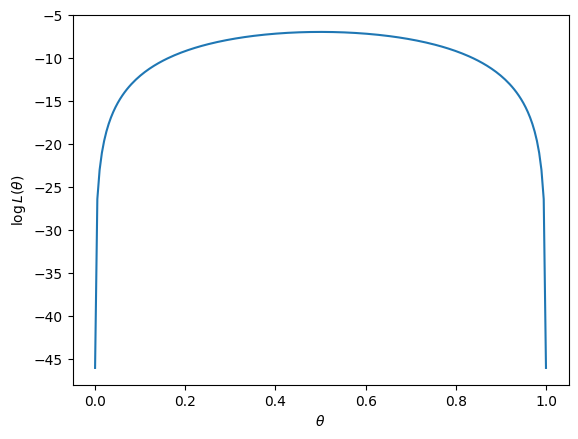

In [4]:
import numpy as np
import matplotlib.pylab as plt

theta_values = np.linspace(0.0001, 0.9999, 200)
ll = lambda theta: 5 * np.log(theta) + 5 * np.log(1 - theta)
plt.plot(theta_values, ll(theta_values))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\log L(\theta)$")
plt.show()

For the Bernoulli distribution, we can derive the maximum likelihood estimator for the Bernoulli distribution analytically, so let us do this. The first derivative is:

$$
\frac{d}{d \theta} \log L(\theta) = \frac{\sum_t x_t}{\theta} - \frac{T - \sum_t x_t}{1-\theta}
$$

Setting the derivative to zero and solving brings us:

$$
\sum_t x_t(1-\theta) = \theta(T - \sum_t x_t) \\
\sum_t x_t - \sum_t x_t \theta = T \theta - \sum_t x_t \theta \\
\sum_t x_t = T \theta \\
\theta = \frac{\sum_t x_t}{T}
$$

The second derivative is:

$$
\frac{d^2}{d^2 \theta} \log L(\theta) = - \frac{\sum_t x_t}{\theta^2} - \frac{T - \sum_t x_t}{\left( 1-\theta \right)^2} < 0
$$

As $\frac{d^2}{d^2 \theta} \log L(\theta) > 0$, $\theta = \frac{\sum_t x_t}{T}$ is the argument which maximizes the likelihood. As you may have already realized this value is just the average value of all observations for $x_t$. For our example this gives us:

$$
\hat{\theta} =  \frac{5}{10} = 0.50
$$

This is the parameter which makes the occurrence of the sample most plausible. In this setting, the parameter represents the probability for the stock price to increase in comparison to the previous day. A value of $0.50$ indicates a strong similarity to a coin toss with a fair coin. 

### Normal distribution

While the random variable with two possible outcomes $\lbrace 0, 1 \rbrace$ is discrete, asset returns are continuous random variables. Let us take a look at its maximum likelihood estimation for the two parameters of the normal distribution. The likelihood function is:

$$
L(\mu, \sigma^2) = \prod_{t=1}^T \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(x_t - \mu)^2}{2\sigma^2}\right)
$$

and after log-transformation the Log-likelihood function:

$$
\log L(\mu, \sigma^2) = \sum_{t=1}^T \log \left(\frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(x_t - \mu)^2}{2\sigma^2}\right)\right)
$$

which can be simplified to:

$$
\log L(\mu, \sigma^2) = -\frac{T}{2} \log (2\pi \sigma^2) - \frac{1}{2\sigma^2} \sum_{t=1}^T (x_t - \mu)^2
$$

By deriving the derivative w.r.t. $\mu$, setting it to zero and solving it, we get the maximum likelihood estimator for it:

$$
\frac{\partial}{\partial \mu} \log L(\mu, \sigma^2) = \frac{1}{\sigma^2} \sum_{t=1}^T (x_t - \mu) = 0 \\
\sum_{t=1}^T x_t - T \mu = 0 \Rightarrow \mu = \frac{1}{T} \sum_{t=1}^T x_i
$$

By deriving the derivative w.r.t. $\sigma^2$, setting it to zero and solving it, we get the maximum likelihood estimator for it:

$$
\frac{\partial}{\partial \sigma^2} \log L(\mu, \sigma^2) = -\frac{T}{2\sigma^2} + \frac{1}{2(\sigma^2)^2} \sum_{t=1}^T (x_t - \mu)^2 = 0 \\
\frac{T}{2\sigma^2} = \frac{1}{2(\sigma^2)^2} \sum_{t=1}^T (x_t - \mu)^2 \Rightarrow \sigma^2 = \frac{1}{T} \sum_{t=1}^T (x_t - \mu)^2
$$

Finally, this means the maximum likelihood estimator for $\mu$ and $\sigma^2$ are the arithmetic mean and the empirical variance (without bias correction):

$$
\hat{\mu} = \frac{1}{T} \sum_t x_t \\
\hat{\sigma}^2 = \frac{1}{T} \sum_t \left( x_t - \hat{\mu} \right)^2
$$

The emphasis of this course is not the derivation of different maximum likelihood estimators, however, by providing these analytical examples, the general mechanism which stands behind it should be demonstrated. Now, let us take a look, how the parameters for different distributions can be done with python's scipy package. Below, we continue the example for Apple's asset returns. First you can see the estimated parameters for the normal, skewed normal, t and skewed t distribution. As the distributions are parametrized in different ways, no comparison can be draw. Given, the distribution is specified by its parameters, its moments can be determined. In the next cell, you can see the estimates for the mean, variance, skewness and kurtosis. Note, that the kurtosis is infinite for the t distribution if the degrees of freedom are below $4$. 

In [5]:
from scipy.stats import norm, skewnorm, t, nct

aapl_returns_train = aapl_returns.loc[:pd.to_datetime("2021-12-31")]
aapl_returns_test = aapl_returns.loc[pd.to_datetime("2021-12-31"):]

theta_norm = norm.fit(aapl_returns_train)
theta_skewnorm = skewnorm.fit(aapl_returns_train)
theta_t = t.fit(aapl_returns_train)
theta_nct = nct.fit(aapl_returns_train)

parameters = {}
distrs = ["normal", "skewed normal", "t", "skewed t"]
parameters["normal"] = np.round(theta_norm, 4)
parameters["skewed normal"] = np.round(theta_skewnorm, 4)
parameters["t"] = np.round(theta_t, 4)
parameters["skewed t"] = np.round(theta_nct, 4)
parameters

{'normal': array([0.0023, 0.0215]),
 'skewed normal': array([-0.9029,  0.0157,  0.0253]),
 't': array([3.1408e+00, 2.5000e-03, 1.3600e-02]),
 'skewed t': array([ 3.153e+00, -3.960e-02,  3.100e-03,  1.370e-02])}

In [6]:
moments_overview = pd.DataFrame(np.nan, index = ["normal", "skewed normal", "t", "skewed t"], columns = ["mean", "variance", "skewness", "kurtosis"])
moments_overview.loc["normal", :] = norm.stats(theta_norm[0], theta_norm[1], moments = "mvsk")
moments_overview.loc["skewed normal", :] = skewnorm.stats(theta_skewnorm[0], theta_skewnorm[1], theta_skewnorm[2], moments = "mvsk")
moments_overview.loc["t", :] = t.stats(theta_t[0], theta_t[1], theta_t[2], moments = "mvsk")
moments_overview.loc["skewed t", :] = nct.stats(theta_nct[0], theta_nct[1], theta_nct[2], theta_nct[3], moments = "mvsk")
moments_overview

,mean,variance,skewness,kurtosis
normal,0.002261,0.000461,0.000000,0.00000
skewed normal,0.002165,0.000459,-0.108725,0.04539
t,0.002474,0.000513,0.000000,inf
skewed t,0.002339,0.000511,-0.636173,NaN


## Evaluation of parametric models

The remaining question is which model is better at capturing the data. When we use maximum likelihood estimation, the likelihood function value for the estimated model can be used as a higher value means it makes the current data sample more plausible. However, remembering that models with more parameters are more flexible, a performance metric should control for this aspect in order to be fair. Two popular metrics with this respect are the Akaike information criterion (AIC) and the Bayesian information criterion (BIC):

$$
AIC = -2 \log L(\boldsymbol{\theta}) + 2p \\
BIC = -2 \log L(\boldsymbol{\theta}) + \log(T)p 
$$

with $T$ being the number of observations and $p$ the number of parameters. The higher the likelihood the smaller $-2 \log L(\boldsymbol{\theta})$, thus, the lower the value of the AIC and the BIC, the better. By adding $2p$ and $\log(T)p$, models with a higher number of parameters are penalized to a larger extent. Hereby, the BIC is more conservative towards more flexible models with a higher number of parameters. 

It is important to understand that the parameters are maximized in the sense that they make the current empirical sample most plausible. Usually, this is not true for new and unseen data due to the randomness when drawing empirical samples. This is why it is also very important to compare performance metrics for out of sample data which usually is called *test* data, while data which is used for estimation is called *training* data. The table below illustrates metrics for training data (2019-2022) and test data (2022-2024/3). For both data sets, we get a consistent result which shows us that the t distribution is best when using the AIC or BIC. While there are many other distributions which can be used for comparison, the t distribution is often a good choice for daily asset returns due to its simplicity (as it only uses three parameters) and its ability to capture heavy tails which helps to assess probabilities for extreme events. 

In [7]:
ll_norm_train = np.sum(norm.logpdf(aapl_returns_train, theta_norm[0], theta_norm[1]))
ll_skewnorm_train = np.sum(skewnorm.logpdf(aapl_returns_train, theta_skewnorm[0], theta_skewnorm[1], theta_skewnorm[2]))
ll_t_train = np.sum(t.logpdf(aapl_returns_train, theta_t[0], theta_t[1], theta_t[2]))
ll_nct_train = np.sum(nct.logpdf(aapl_returns_train, theta_nct[0], theta_nct[1], theta_nct[2], theta_nct[3]))

ll_norm_test = np.sum(norm.logpdf(aapl_returns_test, theta_norm[0], theta_norm[1]))
ll_skewnorm_test = np.sum(skewnorm.logpdf(aapl_returns_test, theta_skewnorm[0], theta_skewnorm[1], theta_skewnorm[2]))
ll_t_test = np.sum(t.logpdf(aapl_returns_test, theta_t[0], theta_t[1], theta_t[2]))
ll_nct_test = np.sum(nct.logpdf(aapl_returns_test, theta_nct[0], theta_nct[1], theta_nct[2], theta_nct[3]))

aic_norm_train = -2 * ll_norm_train + 2*len(theta_norm)
aic_skewnorm_train = -2 * ll_skewnorm_train + 2*len(theta_skewnorm)
aic_t_train = -2 * ll_t_train + 2*len(theta_t)
aic_nct_train = -2 * ll_nct_train + 2*len(theta_nct)

aic_norm_test = -2 * ll_norm_test + 2*len(theta_norm)
aic_skewnorm_test = -2 * ll_skewnorm_test + 2*len(theta_skewnorm)
aic_t_test = -2 * ll_t_test + 2*len(theta_t)
aic_nct_test = -2 * ll_nct_test + 2*len(theta_nct)

T_train = len(aapl_returns_train)
bic_norm_train = -2 * ll_norm_train + np.log(T_train)*len(theta_norm)
bic_skewnorm_train = -2 * ll_skewnorm_train + np.log(T_train)*len(theta_skewnorm)
bic_t_train = -2 * ll_t_train + np.log(T_train)*len(theta_t)
bic_nct_train = -2 * ll_nct_train + np.log(T_train)*len(theta_nct)

T_test = len(aapl_returns_test)
bic_norm_test = -2 * ll_norm_test + np.log(T_test)*len(theta_norm)
bic_skewnorm_test = -2 * ll_skewnorm_test + np.log(T_test)*len(theta_skewnorm)
bic_t_test = -2 * ll_t_test + np.log(T_test)*len(theta_t)
bic_nct_test = -2 * ll_nct_test + np.log(T_test)*len(theta_nct)


eval_distrs = pd.DataFrame(
    np.nan,
    index = ["normal", "skewed normal", "t", "skewed t"],
    columns = ["LL (train)", "AIC (train)", "BIC (train)", "LL (test)", "AIC (test)", "BIC (test)"]
)
eval_distrs.loc[:, "LL (train)"] = [ll_norm_train, ll_skewnorm_train, ll_t_train, ll_nct_train]
eval_distrs.loc[:, "AIC (train)"] = [aic_norm_train, aic_skewnorm_train, aic_t_train, aic_nct_train]
eval_distrs.loc[:, "BIC (train)"] = [bic_norm_train, bic_skewnorm_train, bic_t_train, bic_nct_train]
eval_distrs.loc[:, "LL (test)"] = [ll_norm_test, ll_skewnorm_test, ll_t_test, ll_nct_test]
eval_distrs.loc[:, "AIC (test)"] = [aic_norm_test, aic_skewnorm_test, aic_t_test, aic_nct_test]
eval_distrs.loc[:, "BIC (test)"] = [bic_norm_test, bic_skewnorm_test, bic_t_test, bic_nct_test]
eval_distrs

,LL (train),AIC (train),BIC (train),LL (test),AIC (test),BIC (test)
normal,1830.839849,-3657.679699,-3648.423616,1448.355703,-2892.711407,-2884.044848
skewed normal,1833.708094,-3661.416188,-3647.532064,1447.720324,-2889.440648,-2876.440809
t,1918.162858,-3830.325716,-3816.441591,1477.516490,-2949.032980,-2936.033141
skewed t,1918.200589,-3828.401178,-3809.889012,1477.613655,-2947.227310,-2929.894192


## The bias-variance tradeoff

Since we have just discussed the topic of different estimates for different data sets, let us take this opportunity to briefly discuss a very important principle for the estimation of models - the bias-variance tradeoff. To keep things simple, let's use a more general example - the toss of a fair coin. A proper distribution for a coin coss would be the Bernoulli distribution whose parameter $\theta = 0.5$ if the coin is fair. Assume that we toss a coin $n$ times to create a single data set. For every data set, we compare two estimators. Estimator one is the one we derived by maximum likelihood estimation and it is given by:

$$
\text{Estimator one: } \hat{\theta} = \frac{1}{n} \sum_i x_i
$$

Without a reasonable derivation, we also try to estimate the true parameter by another estimator which is given by:

$$
\text{Estimator two: } \hat{\theta} = \frac{1}{n+5} \sum_i x_i
$$

Let $n = 100$, however, we not only conduct our estimation experiment once, we repeat it $10,000$ times and record all estimates for estimator one and two for every data sample. Below, we first take a look at the empirical distributions of these estimates. We can see that the realizations for estimator two seem to be systematically lower than the ones for estimator two. At the same time, the distribution for estimator one realizations seems to be a little wider.

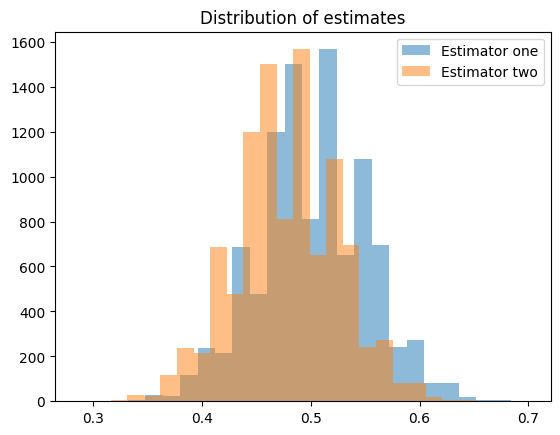

In [8]:
from scipy.stats import bernoulli
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

n = 100
estimator_one, estimator_two = [], []
for _ in range(10000):
    x_tmp = bernoulli.rvs(p = 0.5, size = n)
    estimator_one.append(x_tmp.mean())
    estimator_two.append(x_tmp.mean() * n/(n+5))

plt.hist(estimator_one, alpha = 0.5, bins = 25, label = "Estimator one")
plt.hist(estimator_two, alpha = 0.5, bins = 25, label = "Estimator two")
plt.title("Distribution of estimates")
plt.legend()
plt.show()

These observations can be quantified by calculating the arithmetic mean and variance for realizations of estimator one and two, respectively. While estimates of estimator one are almost perfectly equal to the true parameter value, estimates for estimator two estimates are on average below the true parameter value. This systematic underestimation is called bias (systematic overestimation is also called bias). Formally let $\hat{\theta}$ be the estimator for an unkown parameter value, then the bias is defined by:

$$
\text{bias}(\hat{\theta}) = E(\hat{\theta}) - \theta 
$$

However, the variance of estimator two is lower. This is a desirable property. Given that we only use a single data set in real life applications to estimate parameters, it is of great value that these estimates tend to vary less for different data sets, otherwise, decision which are based on these estimates are exposed to the randomness in data. The variance of an estimator is formally defined by:

$$
\text{variance}(\hat{\theta}) = E \left[ \left( \hat{\theta} - E(\hat{\theta}) \right)^2 \right]
$$

In our example, the variance of the biased estimator two is lower than the one for estimator. This exposes us to the classical bias-variance tradeoff as we need to decide among an unbiased estimator with higher variation and a biased estimator with lower variation. 

In [9]:
pd.DataFrame(
    [[np.mean(estimator_one), np.mean(estimator_two)], [np.var(estimator_one, ddof = 1), np.var(estimator_two, ddof = 1)]],
    index = ["Avg. of estimates", "Std. of estimates"],
    columns = ["Estimator one", "Estimator two"]
    ).round(4)

,Estimator one,Estimator two
Avg. of estimates,0.5011,0.4773
Std. of estimates,0.0025,0.0023


Usually, in realistic scenarios, this leads to a decision between simpler and more complex models. Usually, the latter have more parameters and are exposed to higher statistical uncertainty when estimating these parameters which increases the variation of these models. However, simpler models are often not flexible enough to capture real-world dynamics adequately which introduces systematic mis-specifications, i.e., bias. 

## The relationship between profit and risk

So far, we discussed the technical aspect of a parametric model for an asset return distribution. But what is important for investors when they examine return distributions, either by empirical estimates or by a parametric model. In short, traditional financial theories have a large emphasis on the mean and the standard deviation of return distributions. The former represents the profitability of an investment. Higher values for the return's mean imply a higher growth in value over time. The standard deviation is used to quantify the risk of an investment. But why? The standard deviation is the square root of the variance which is the expected value of squared deviations from the mean. A negative deviation from the mean is likely to be considered as something negative from an investor's perspective as the value development of an asset is below average. However, a positive deviation is obviously a good day for an investor because the investment grows larger than expected. Given higher variance for an investment, we may have a higher chance for bad days, however to the same extent also the chance for very good days as well, so why is this considered to be more risky in terms of something investors tend to fear or avoid to a certain degree?

The reason is that investors usually are *risk averse*. Risk aversion is a concept which comes from utility theory. Let $w$ be the wealth we have and $U$ a function which assigns the utility for having wealth $w$. If an investor is risk averse, her utility function is a concave function like the one visualized below:

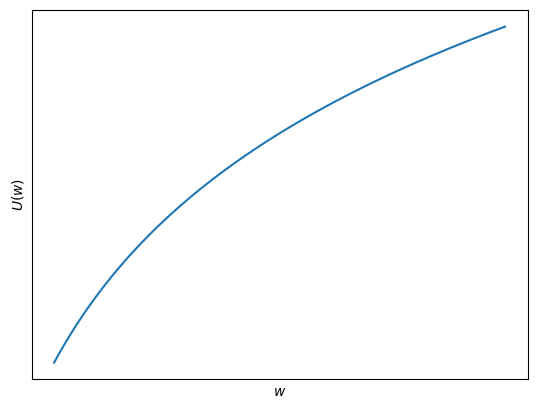

In [10]:
import matplotlib.pylab as plt
import numpy as np

w = np.linspace(1, 5, 200)
uw = np.log(w)

plt.plot(w, uw)
plt.xticks([])
plt.yticks([])
plt.xlabel(r"$w$")
plt.ylabel(r"$U(w)$")
plt.show()

If the utility function is concave, it means the increase in utility from one more unit of $w$ is smaller than the decrease in utility from the loss of one unit of $w$. If this is true, than investors put a larger weight on potential (high) losses than the corresponding potential (high) gains. Only under these circumstances, high variation becomes something which reduces utility and needs to be avoided to a certain extent. Given that not all investors have exactly the same utility function, some may be willing to bear more risks than others (while all are still risk averse). 

Another important thought in this context is the relation between profit and risk. More profitable assets are more risky if all market participants behave rational. Intuitively, this can be explained by the following thought. Assume, two assets exist which are identically profitable, while the second asset has a higher risk level. In this scenario, no rational investor would purchase asset number two. Thus, asset number two can only exist if it becomes more profitable than asset number one. The relation between profitability and risk is almost a natural law on financial markets. However, in real-life, it is not as easy as it sounds, as profitability and risk of an asset is unknown and needs to be estimated. Furthermore, risk may be more than "just" the standard deviation, and, some sources of risk may be less important to investors than others. While we come back to the last point later, let us quickly discuss risk metrics different from standard deviation. 

Other risk measures have a greater focus on the potential downside of investment and business decisions. Examples for so called *downside* risk measures are the *Value-at-Risk (VaR)*, *Expected Shortfall (ES)*, *Lower Partial Moments (LMP)* or *Expectiles*. The most popular ones are likely the VaR and the ES as both also play important roles in the regulation of financial markets. It is common to define both from the perspective of a loss function. For an asset return, the random loss variable can simply be redefined by: $l_t = -r_t$, thus, profits are negative and losses are positive values. The VaR is the upper $\alpha$ quantile of the loss distribution, so technically:

$$
VaR_t^{\alpha}(l_t) = F_l^{(-1)}(\alpha) = \inf \lbrace l_t | F_l(l_t) \geq \alpha \rbrace
$$

$\alpha$ is often called the confidence level in this context. Furthermore, the verbal VaR definition usually includes the time dimension. For instance if we determine the VaR based on daily returns ($l_t = -r_t$), then, the $VaR_t^{\alpha}(l_t)$ is the loss which is only exceeded with a probability of $1 - \alpha$ within a given day. Note that the VaR can directly be determined by the return distribution, given the distribution function is continuous and strictly monotone:

$$
VaR_t^{\alpha}(l_t) = -VaR_t^{1 - \alpha}(r_t) = F_r^{-1}(1-\alpha)
$$

One potential disadvantage of the VaR is that it does not include the information for losses being higher than itself. This means two loss distributions which have the same $\alpha$ quantile are equally risky even though one of them may have higher probability mass in the tail beyond the quantile. If this is true, losses which exceed the quantile will be higher on average. This would not be ignored if we further quantify the risk by the Expected Shortfall which is the expected loss, conditional the loss exceeds a (critical) level. Formally, it can be defined by:

$$
ES_t^{\alpha}(l_t) = \frac{1}{1 - \alpha} \int_\alpha^1 F_l^{-1}(u) du
$$

So empirically, it is the average of losses which exceed the Value-at-Risk. Popular confidence levels for the VaR are $99$\% and $97.5$\% for the ES. We leave it with the presentation of these two risk measures. Both have interesting (and partly different properties). During the course, we sometimes may come back to these, but mostly focus on volatility first and report the VaR indirectly by taking reporting lower quantiles of the return distribution. 

## Interim conclusion: Examining the unconditional asset return distribution

So what might be useful if we analyze an unconditional asset return distribution? We can visualize the asset return distribution and we can make use of empirical estimates for metrics which characterize the distribution. We can furhter determine these estimates under the assumption of a parametric model and we can use a parametric model to simulate asset return data. The question if it is better to use empirical estimates or a parametric model leads to a discussion without a clear winner. Both approaches have advantages and disadvantages. Empirical estimates do not make and restricting assumptions and are very flexible. At the same time, they need more data to reduce the exposure to statistical uncertainty and it is difficult to extrapolate data which is not present in the empirical data sample. Parametric models are usually a simplification of reality and sometimes maybe too restrictive which can lead to bias in assessments made by the parametric model. At the same time, they often allow simpler calculations and, thus, can be very efficient from a computational perspective. This is why including estimates from both approaches may be desirable if possible. For instance, we can compare empirical estimates to the ones of a reasonable parametric distribution. Including multiple approaches creates resilience towards the risk of choosing the wrong model and it can create further create insights when exploring the source of differences for these estimates.

As we discussed in the last chapter, even though a graphic can say more than 1,000 metrics, visualizations become unhandy if we need to analyze a larger number of asset return distributions at the same time (e.g., all stocks from the Nasdaq 100). This is why we focus on metrics from the distribution. Taking together all we learned so far, we may agree upon the following ones:

* mean
* volatility
* skewness
* kurtosis
* lower and upper quantiles

So let us take a look at our example which examine Apple's daily returns for the past five years:

In [11]:
aapl_returns.describe(percentiles = [0.01, 0.025, 0.975, 0.99])
aapl_returns.skew()
aapl_returns.kurtosis()
descriptives = aapl_returns.describe(percentiles = [0.01, 0.025, 0.975, 0.99])
descriptives.loc["skew"] = aapl_returns.skew()
descriptives.loc["kurtosis"] = aapl_returns.kurtosis()
descriptives = descriptives.loc[["mean", "std", "skew", "kurtosis", "1%", "2.5%", "97.5%", "99%"]]
descriptives = descriptives.to_frame("empirical")

norm_fit = norm.fit(aapl_returns)
t_fit = t.fit(aapl_returns)
nct_fit = nct.fit(aapl_returns)

ll_norm = np.sum(norm.logpdf(aapl_returns, norm_fit[0], norm_fit[1]))
ll_t = np.sum(t.logpdf(aapl_returns, t_fit[0], t_fit[1], t_fit[2]))
ll_nct = np.sum(nct.logpdf(aapl_returns, nct_fit[0], nct_fit[1], nct_fit[2], nct_fit[3]))
aic_norm = -2 * ll_norm + 2 * len(norm_fit)
aic_t = -2 * ll_t + 2*len(t_fit)
aic_nct = -2 * ll_nct + 2*len(nct_fit)

norm_quantiles = norm.ppf([0.01, 0.025, 0.975, 0.99], norm_fit[0], norm_fit[1])
norm_moments = norm.stats(norm_fit[0], norm_fit[1], moments = "mvsk")

t_quantiles = t.ppf([0.01, 0.025, 0.975, 0.99], t_fit[0], t_fit[1], t_fit[2])
t_moments = t.stats(t_fit[0], t_fit[1], t_fit[2], moments = "mvsk")

nct_quantiles = nct.ppf([0.01, 0.025, 0.975, 0.99], nct_fit[0], nct_fit[1], nct_fit[2], nct_fit[3])
nct_moments = nct.stats(nct_fit[0], nct_fit[1], nct_fit[2], nct_fit[3], moments = "mvsk")

descriptives.loc["mean":"kurtosis":, "normal"] = norm_moments
descriptives.loc["std", "normal"] = np.sqrt(descriptives.loc["std", "normal"])
descriptives.loc["1%":, "normal"] = norm_quantiles

descriptives.loc["mean":"kurtosis":, "t"] = t_moments
descriptives.loc["std", "t"] = np.sqrt(descriptives.loc["std", "t"])
descriptives.loc["1%":, "t"] = t_quantiles

descriptives.loc["mean":"kurtosis":, "skew_t"] = nct_moments
descriptives.loc["std", "skew_t"] = np.sqrt(descriptives.loc["std", "skew_t"])
descriptives.loc["1%":, "skew_t"] = nct_quantiles

descriptives.loc["LL", :] = np.nan
descriptives.loc["AIC", :] = np.nan
descriptives.loc["LL", ["normal", "t", "skew_t"]] = [ll_norm, ll_t, ll_nct]
descriptives.loc["AIC", ["normal", "t", "skew_t"]] = [aic_norm, aic_t, aic_nct]
descriptives

,empirical,normal,t,skew_t
mean,0.001348,0.001348,0.001515,0.001338
std,0.020042,0.020035,0.020538,0.020516
skew,-0.036195,0.000000,0.000000,-0.275566
kurtosis,5.328365,0.000000,inf,NaN
1%,-0.052571,-0.045260,-0.053083,-0.054289
2.5%,-0.038561,-0.037919,-0.038270,-0.039036
97.5%,0.037571,0.040615,0.041300,0.040490
99%,0.051358,0.047956,0.056113,0.054763
LL,NaN,3283.601280,3396.110267,3396.272700
AIC,NaN,-6563.202561,-6786.220534,-6784.545400


The mean and standard deviation are rather similar for the empirical estimate and corresponding estimates from the parametric models. The distribution seems to be leptokurtic and slightly left-skewed. Rare but rather extreme observations for the asset return are beyond $0.035$ on an absolute scale. Comparing the parametric models according to the AIC favors the t distribution. The normal distribution is the worst which is likely due to its inability to adequatly capture the frequency of more extreme realizations. If Apple is a favorable investment in comparison to others depends on the corresponding metrics of alternatives and the way how we evaluate it. This is something which we are going to discuss later in the course in line with the discussion of some fundamental financial market theories.

## Conditional parametric models for asset returns

From the last chapter we learned that returns seem to behave different over time. When we ignore this fact, we say a return is independent and identically distributed. This means if we simulate data for a time series of asset returns, we draw one random number for every point in time $t$ from the same distribution. Let us do this for the best distribution found in the example above, the t distribution. Below you can see that simulated data fails to capture the behavior during the Covid crisis. Especially the level of variation is too low for simulated data points. This indicates that asset returns seem not to be independent and identically distributed over time. While the autocorrelation is rather low for returns, it is higher for absolute values. The assumption of an identical distribution seems to be wrong because at least the level of variation is not identical over time. 

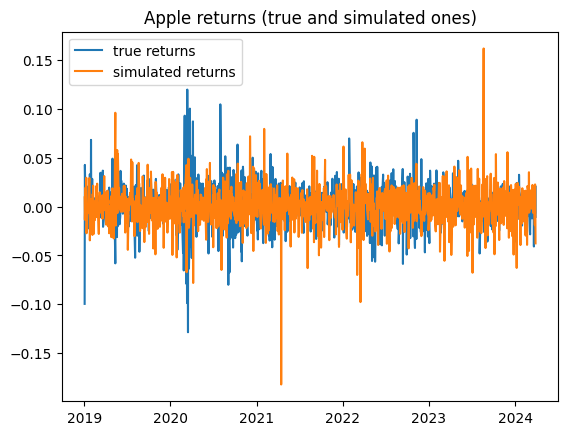

In [12]:
plt.plot(aapl_returns, label = "true returns")
plt.plot(aapl_returns.index, t.rvs(t_fit[0], t_fit[1], t_fit[2], size = aapl_returns.shape[0], random_state =42), label = "simulated returns")
plt.legend()
plt.title("Apple returns (true and simulated ones)")
plt.show()

Popular models that capture time-varying properties of distributions often are of the following form:

$$
r_t = \mu_t +  \epsilon_t \\
\epsilon_t = \sigma_t e_t
$$

where $\mu_t$ and $\sigma_t$ are the time-varying mean and standard deviation of $r_t$ and $e_t$ is a random variable with zero mean and unit variance; $\sigma_t$ are denoted as the residuals and $e_t$ are often called the innovations. The distribution of $e_t$ may have further parameters which can impact its shape, but, these are assumed to be identical over time. The formula basically decomposes the distribution of $r_t$ into three components: its mean $\mu_t$, its standard deviation $\sigma_t$ and its random variation after it has been filtered for its mean and standard deviation. 

We only take a look at one popular model for the mean and the standard deviation each to illustrate how time-varying parametric models can be constructed. To model a time-varying mean, we take a look at the autoregressive process of order one AR(1):

$$
r_t = \mu + \phi r_{t-1} + \epsilon_t
$$

Here, $\mu$ and $\phi \in (-1, 1)$ are parameters which impact the time-conditional mean of $r_t$ because independent of $\epsilon$, the expected value at time $t$ is determined by:

$$
\mu_{t} = \mu + \phi r_{t-1}
$$

This model creates time series data with correlation if $\phi \neq 0$. For $\phi > 0$, today's expectation is higher (lower) for higher (lower) values of the return from the previous time period $t-1$. The reverse is true for $\phi < 0$. This model can be extended to autoregressive processes of order $p$, AR($p$) by including more lagged values from the present. 

To capture the time-varying nature of the standard deviation, one models the variance in a similar manner. A popular model with this respect  is the GARCH model which stands for *generalized autoregressive conditional heteroscedasticity*. The GARCH(1,1) model defines the time-varying variance by:

$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

$\omega > 0, \alpha \geq 0, \beta \geq 0$ are parameters of the variance model. Re-arranging the return process equation to:

$$
\epsilon_t = r_t - \mu_t
$$

highlights that the conditional variance is higher (lower) if the deviation from the mean in the previous period has been higher (lower) and if the conditional variance has been higher (lower) in the previous time step. To define the asset return model completely, we need to make an assumption for the distribution of $e_t$. For instance, $e_t$ can be assumed to be normally distributed or to follow a standardized (with zero mean and unit variance) student t distribution which is defined by an additional parameter which impacts the kurtosis of the distribution. 

Technically, this defines a model for a stochastic process, and, usually *(weakly) stationary* processes are used for asset returns. In general, a process $r_1, r_2, ..., $ is called weakly stationary, if: 

* $E(r_t) = \mu, ~ \forall t$
* $Var(r_t) = \sigma^2, ~ \forall t$
* $Cov(r_t, r_s) = \gamma(|t -s|), ~ \forall t, s$ and some function $\gamma(k)$

Weakly stationary makes sure that the return distribution has identical characteristics over time, but, not in time. **This distinction is very important in my opinion to understand the difference between the unconditional and the conditional perspective**. Let us illustrate this with the expected value. Formally, the difference between

$$
E(r_t) = \mu
$$

and

$$
E(r_t | \mathcal{F}_{t-1}) = \mu_t
$$

highlights that different perspectives influence the expectation for time $t$. Loosely speaking, $\mu$ is what we expect on average over time, while $\mu_t$ uses the current information $\mathcal{F}_{t-1}$, to build the expectation for today. You may picture it like this, given positive autocorrelation of returns, we would expect the return for today to be higher (lower), if yesterday's return has been higher (lower). This is a conditional perspective and what $\mu_t$ represents. The unconditional counterpart $\mu$ ignores yesterday's return and builds its estimate by including returns after days with high and low returns. In an analogue way, you can think the same way about the distinction between $\sigma_t$ and $\sigma$.

```{note}
While we only quickly discuss these models, please note that these models come from the field of time series analysis which discusses many interesting properties of stochastic processes that are useful in the financial domain. 

Further note that $ |\phi| < 1$ is a necessary condition for the AR(1) process to be stationary and $\omega > 0, \alpha \geq 0, \beta \geq 0$ are necessary restrictions for the variance to be positive. 
```

### Estimation of AR-GARCH models 

The parameters of the AR-GARCH model can also be estimated by maximum likelihood estimation. Let us take a look how this would be done if we assume that returns are assumed to be normally distributed, i.e., $r_t \sim N\left( \mu_t, \sigma_t \right) $. At any point in time $t$, wen can determine according to the formulas from above, given we set the parameters $\mu, \phi, \omega, \alpha, \beta$.

The likelihood is:

$$
L\left(\mu, \phi, \omega, \alpha, \beta \right) = \prod_{t=1}^T f(r_t | \mu, \phi, \omega, \alpha, \beta) = \prod_{t=1}^T f(r_t | \mu_t, \sigma_t)
$$

The values for $\mu_t, \sigma_t^2$ need to be calculated recursively which is fairly easy except for the first observation. For $t = 1$, we have:

$$
\mu_{1} = \mu + \phi r_{0}
$$

Depending on how we interpret it, $r_0$ is not observable. Thus a reasonable starting value for $\mu_1$ must be set. Different values can be proposed, however a common choice could be the unconditional mean estimate of the time series. In a similar way, a starting value for $\sigma_0^2$ must be set. Again, different values can be tested, e.g., the unconditional variance estimate. Given these starting values, it gets easy to determine $\mu_t, \sigma_t^2$ for all points in time and determine the likelihood value at every point in time. The estimation searches for the parameter values for $\mu, \phi, \omega, \alpha, \beta$ which result in the highest likelihood value. Note that these parameters usually are also consistent and unbiased even $r_t$ is not normally distributed in reality. Furthermore, the process can easily be defined for other parametric distributions with further parameters. For instance, for a student t distribution, we only need to further estimate the degrees of freedom which would be considered to be constant over time.

### In sample calculation and prediction

After the parameters are estimated, we can take a look at the parameters of the model and analyze the variation in the mean and standard deviation over time. The output below provides a summary of the AR(1)-GARCH(1, 1) model which has been estimated to Apple's returns between 2019 and 2021. The value for $\hat{\phi} = -0.1044$ indicates moderate autocorrelation with varying above and below average returns over time. The parameters of the GARCH(1,1) model indicate a rather strong relationship between current the deviation from the mean at time $t-1$ and $t$. 

In [13]:
from arch import arch_model

aapl_returns_ts = aapl_returns*100
aapl_returns_ts_train = aapl_returns_ts.loc[:pd.to_datetime("2021-12-31")]
aapl_returns_ts_test = aapl_returns_ts.loc[pd.to_datetime("2021-12-31"):]

end_training_date = pd.to_datetime("2021-12-31")
am = arch_model(aapl_returns_ts, mean = "AR", lags = 1, vol = "GARCH", dist="StudentsT")
res = am.fit(last_obs = end_training_date)
res.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 12785.182362045536
Iteration:      2,   Func. Count:     19,   Neg. LLF: 30209.621230879457
Iteration:      3,   Func. Count:     28,   Neg. LLF: 11919.307278771486
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1721.7366089674938
Iteration:      5,   Func. Count:     48,   Neg. LLF: 1637.3888267981383
Iteration:      6,   Func. Count:     57,   Neg. LLF: 1498.612322499288
Iteration:      7,   Func. Count:     64,   Neg. LLF: 1498.5657293905033
Iteration:      8,   Func. Count:     71,   Neg. LLF: 1498.555925174687
Iteration:      9,   Func. Count:     78,   Neg. LLF: 1498.553068549892
Iteration:     10,   Func. Count:     85,   Neg. LLF: 1498.5527279992957
Iteration:     11,   Func. Count:     92,   Neg. LLF: 1498.5526964219978
Iteration:     12,   Func. Count:     99,   Neg. LLF: 1498.5526947481756
Iteration:     13,   Func. Count:    105,   Neg. LLF: 1498.5526947481749
Optimization terminated successfully    (Exit mode 0)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                         AAPL   R-squared:                       0.029
Mean Model:                              AR   Adj. R-squared:                  0.028
Vol Model:                            GARCH   Log-Likelihood:               -1498.55
Distribution:      Standardized Student's t   AIC:                           3009.11
Method:                  Maximum Likelihood   BIC:                           3036.86
                                              No. Observations:                  754
Date:                      Thu, Jun 06 2024   Df Residuals:                      752
Time:                              11:30:48   Df Model:                            2
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.3169  5.684e-02      5.575  2.478e-08    [  0.205,  0.428]
AAPL[1]       -0.1044  3.704e-02     -2.819  4.811e-03 [ -0.177,-3.183e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1721  5.920e-02      2.907  3.652e-03 [5.605e-02,  0.288]
alpha[1]       0.1234  3.112e-02      3.964  7.370e-05 [6.237e-02,  0.184]
beta[1]        0.8368  3.282e-02     25.494 2.279e-143   [  0.772,  0.901]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.4945      1.017      5.404  6.523e-08 [  3.502,  7.487]
========================================================================

Covariance estimator: robust
"""

The figure below illustrates the asset returns and compares them to a few time-varying metrics which are derived by means of the AR(1)-GARCH(1,1) model. In the plots in the first row, we can compare the realizations to the conditional mean and standard deviation. Especially the right plot shows the capability of the GARCH(1,1) model to capture the time-varying behavior of the volatility. 

The plots in the second row show the time-varying 5% quantile which can be derived by:

$$
r_{t, 0.05} = \mu_t + \sigma_t e_{t, 0.05}
$$

where $e_{t, 0.05}$ is the quantile of the innnovation's distribution. One can either determine the quantile by the assumed distribution of the process or empirically after the parameters are estimated and realizations for $e_t$ can be calculated. The latter is called filtered historical simulation. The meaning for this name comes from the mechanism of the model. The residuals $\epsilon_t = r_t - \mu_t$ have a mean of zero (approximately for empirical data), thus, $\epsilon_t$ are mean filtered realizations of $r_t$. If we further determine the innovations by: $e_t = \epsilon_t / \sigma_t$, the realizations are volatility filtered as well which is why $e_t$ have unit variance (and zero mean). 

The orange line in the left plot of the second row represents adverse return levels over time. If the mean is lower and standard deviation is higher during a critical market phase such as the Covid period in the beginning of 2020, lower quantile levels are lower as well. In case of the 5% quantile, we determine a return realization for which even lower returns occur with a probability of 5%. During the Covid period, this level is aroung $-0.12$. In comparison, the unconditional 5% quantile is only $-0.03$. This implicitly shows us that return levels which would be considered to be rather extreme over time occur more often during a crisis period. These observations highlight the difference between the unconditional and conditional perspective. Even though a return of around $-0.03$ is a rather rare event over the whole time period, we should be prepared for more extreme and adverse events, given we currently observed large deviations from the mean. 


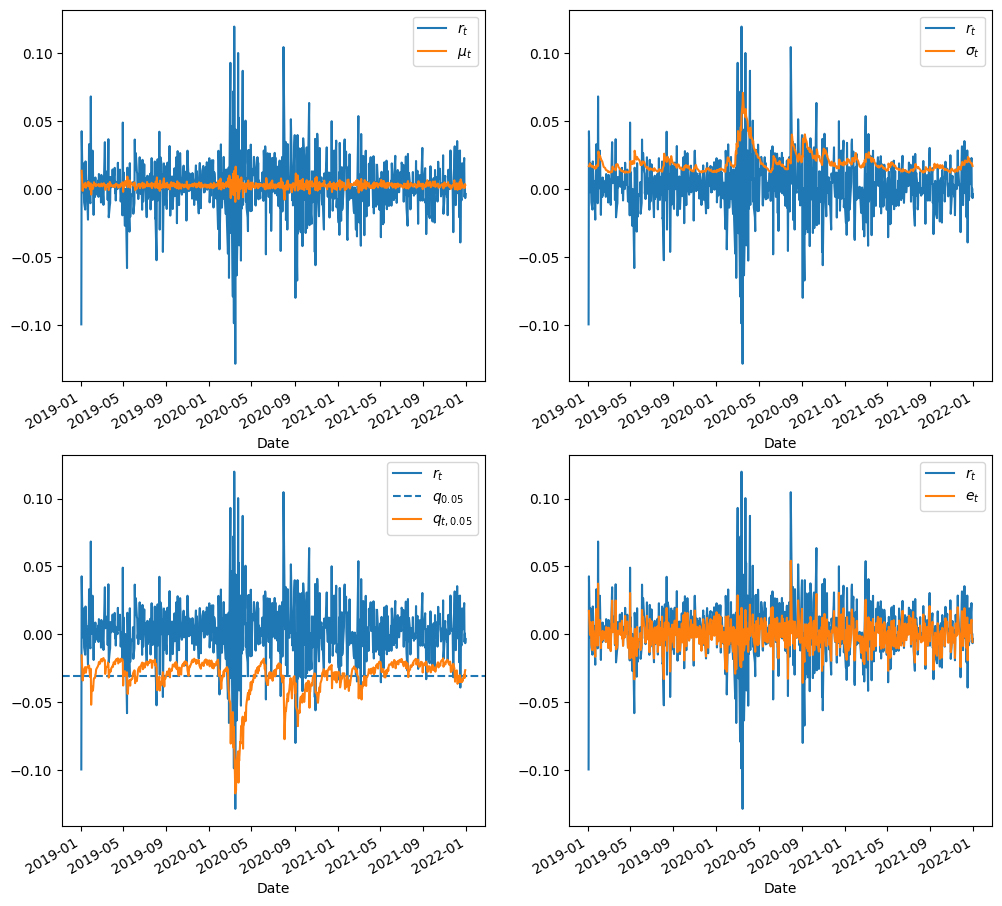

In [14]:
import matplotlib.pylab as plt

mu_t = aapl_returns_ts.loc[:end_training_date] - res.resid.loc[:end_training_date]
sigma_t = res.conditional_volatility.loc[:end_training_date]
e_t = (res.resid.loc[:end_training_date] / sigma_t)
q = e_t.quantile(0.05)
q_t = mu_t + sigma_t * q  

fig, axs = plt.subplots(2, 2, figsize = (12, 12))
aapl_returns_ts.loc[:end_training_date].divide(100).plot(ax = axs[0, 0], label = r"$r_t$")
aapl_returns_ts.loc[:end_training_date].divide(100).plot(ax = axs[0, 1], label = r"$r_t$")
aapl_returns_ts.loc[:end_training_date].divide(100).plot(ax = axs[1, 0], label = r"$r_t$")
axs[1, 0].axhline(aapl_returns.loc[:end_training_date].quantile(0.05), linestyle = "dashed", label = r"$q_{0.05}$")
aapl_returns_ts.loc[:end_training_date].divide(100).plot(ax = axs[1, 1], label = r"$r_t$")
q_t.divide(100).plot(ax = axs[1, 0], label = r"$q_{t, 0.05}$")
axs[1, 0].legend()
e_t.divide(100).plot(ax = axs[1, 1], label = r"$e_t$")
axs[1, 1].legend()
mu_t.divide(100).plot(ax = axs[0, 0], label = r"$\mu_t$")
axs[0, 0].legend()
sigma_t.divide(100).plot(ax = axs[0, 1], label = r"$\sigma_t$")
axs[0, 1].legend()
plt.show()

This model can be used to predict data as well by adjusting the time index accordingly. So for the mean, we have:

$$
\mu_{t+1} = \mu + \phi r_{t}
$$

for the variance:

$$
\sigma_{t+1}^2 = \omega + \alpha \epsilon_{t}^2 + \beta \sigma_{t}^2
$$

and, for instance, for a quantile:

$$
r_{t + 1, \alpha} = \mu_{t+1} + \sigma_{t+1} e_{t, \alpha}
$$

However, the benefits of this forecast should not be overestimated in times of crisis. Conservative forecasts only begin after at least one adverse event has already been observed for $r_t$ or for $\epsilon_t^2$. The model is not able to forecast the start of a crisis if only moderate price movements have occurred beforehand. This is why these models usually fail to provide accurate risk estimates during a crisis, however, are accurate on average over longer time periods. 

Nevertheless, these models provide valuable insights w.r.t. to the estimates of asset return distribution during critical and booming periods as well. For instance, an investor may use the levels of returns and standard deviations from a crisis period as a conservative risk estimate which  my prepare her for loss levels during upcoming crisis period in the future.